In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt


## Calculate Magnetic field at position P

In [6]:

def get_B(P):
    R = 0.7
    A = [0.39, 0.4, 0.5]
    P = [0.2, -0.5]
    B = [1,0.5,2]
    G = [0, -2, 0.3]
    
    a = A
    A = []
    curr = 0
    for i in range(len(a)):
        A.append([curr, curr + float(a[i])])
        curr += float(a[i])
    
    # Step 1: check what point it is
    x = P[0]
    y = P[1]

    # Initialize output
    Bout = 0
    
    # Update output, if needed
    for k in range(len(A)):
        m1 = math.tan(math.pi/2 - float(A[k][0]))
        m2 = math.tan(math.pi/2 - float(A[k][1]))
        if y < m1*x - R and y >= m2*x - R:  # if P is in Area k
            d = math.sqrt(x**2 + (y-(-R))**2)
            h = R - d

            Bout = float(B[k])+ float(G[k])*h
            break


    return Bout

In [7]:

B = get_B([0.4, -0.3])



## Beam Rigidity

In [8]:
B_e = 3.3356*0.1

In [9]:
B_e

0.33356

## Radius

In [10]:
R = B_e/B
D = [0,1]
R

-0.9977429190736081

## New position

In [11]:
def next_point(r, P, d):
    R = np.array([[0, 1],
            [-1, 0]]) # Defining the rotation matrix in a clockwise direction
    s = 0.001
    d = np.array(d) # The direction of the point
    pc = np.matmul(R, d) # Multiplying the two matrices together to get the vector going from the point to the center

    Cx = P[0]+r*pc[0]
    Cy = P[1]+r*pc[1]
    c = np.array([Cx, Cy])

    CP = np.subtract(P, c) # Subtracting the center from the point to find CP
    theta = s/r

    R = np.array([[np.cos(-theta), -np.sin(-theta)],
            [np.sin(theta), np.cos(-theta)]]) # Defining the rotation matrix in a clockwise direction
    CP2 = np.matmul(R, CP)
    P = np.add(c,CP2) # Adding the distance from the center of the circle with the coordinates of the center to find the coordinates of the new point

    counter_R = np.array([[0, -1],
            [1, 0]]) # Defining the rotation matrix in a counter-clockwise direction
   
    D = np.matmul(counter_R, CP2)

    return P, D

In [12]:
P = [0,0]
D = [1,0]

points = []
for i in range(2):
    B = get_B(P)
    B_e = 3.3356*0.1 # Beam Rigidity
    R = B_e/B # Radius
    P, D = next_point(R,P,D)
    points.append(P)

In [13]:
print(points)

[array([9.99999833e-04, 5.01131052e-07]), array([1.99774158e-03, 1.13109344e-09])]


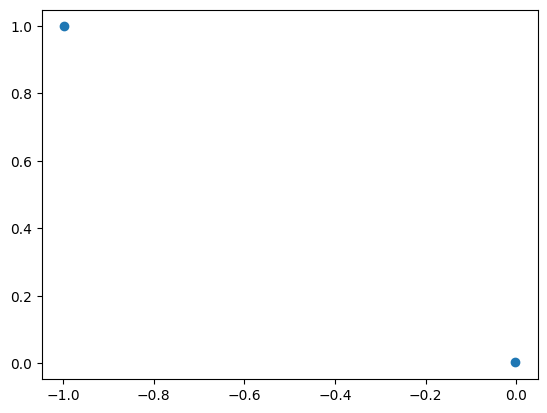

In [89]:
#points


# Split the data into x and y coordinates for plotting
x = [point[0] for point in points]
y = [point[1] for point in points]

# Create the plot
plt.scatter(x, y)

# Display the plot
plt.show()

In [21]:
!pip3 install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 15.5 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 14.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 10.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip


In [32]:


def get_B_known_param(P):
    R = 0.7
    A = [0.39, 0.4, 0.5]
    P = [0.2, -0.5]
    B = [1,0.5,2]
    G = [0, -2, 0.3]
    
    a = A
    A = []
    curr = 0
    for i in range(len(a)):
        A.append([curr, curr + float(a[i])])
        curr += float(a[i])
    
    # Step 1: check what point it is
    x = P[0]
    y = P[1]

    # Initialize output
    Bout = 0
    
    # Update output, if needed
    for k in range(len(A)):
        m1 = math.tan(math.pi/2 - float(A[k][0]))
        m2 = math.tan(math.pi/2 - float(A[k][1]))
        if y < m1*x - R and y >= m2*x - R:  # if P is in Area k
            d = math.sqrt(x**2 + (y-(-R))**2)
            h = R - d

            Bout = float(B[k])+ float(G[k])*h
            break


    return Bout

def next_point(r, P, d):
    R = np.array([[0, 1],
            [-1, 0]]) # Defining the rotation matrix in a clockwise direction
    s = 0.001

   # d = np.array(d) # The direction of the point
    pc = np.matmul(R, d) # Multiplying the two matrices together to get the vector going from the point to the center

    Cx = P[0]+r*pc[0]
    Cy = P[1]+r*pc[1]
    c = np.array([Cx, Cy])

    CP = np.subtract(P, c) # Subtracting the center from the point to find CP
    theta = s/r

    R = np.array([[np.cos(-theta), -np.sin(-theta)],
            [np.sin(theta), np.cos(-theta)]]) # Defining the rotation matrix in a clockwise direction
    CP2 = np.matmul(R, CP)
    P = np.add(c,CP2) # Adding the distance from the center of the circle with the coordinates of the center to find the coordinates of the new point

    counter_R = np.array([[0, -1],
            [1, 0]]) # Defining the rotation matrix in a counter-clockwise direction

    D = np.matmul(counter_R, CP2)

    return P, D    


def get_points(P, D, size):

    # Compute the magnitude (or norm) of the vector
    magnitude = np.linalg.norm(D)

    # Normalize the vector
    D = D/magnitude   
    print(D)
    points = []
    for i in range(size):
        B = get_B_known_param(P)
        B_e = 3.3356*0.1 # Beam Rigidity
        R = B_e/B # Radius
        P, D = next_point(R,P,D)
        points.append(P)


    # Splitting the data into x and y coordinates for plotting
    x = [point[0] for point in points]
    y = [point[1] for point in points]


    return points
    # Create the plot
# plt.scatter(x, y)

    # Display the plot
#    plt.show()



get_points([0,0], [3,4], 1)

[0.6 0.8]


[array([ 0.0005996, -0.0007997])]